# Example how to use CSC STAC API, xarray and dask

This example shows how tu use [STAC](https://stacspec.org/en/about/) (Spatio-Temporal Asset Catalog) API, [xarray](https://docs.xarray.dev/en/stable/) and [Dask](https://www.dask.org/) for processing big raster datasets, also with good support for time series. The main idea is to first define the search and processing as process graph. The downloading and processing is done lazily at the end, so that only needed data (good enough cloud-free image, only needed bands and area) is downloaded. The libraries take care of data download, so you do not need to know about file paths. These tools work best when data is provided as [Cloud-optimized GeoTiffs](https://www.cogeo.org/) (COGs).

For trying out this example, it is recommended to start interactive [Jupyter session](https://docs.csc.fi/computing/webinterface/jupyter/) with [Puhti web interface](https://docs.csc.fi/computing/webinterface/), for example with 1 cores and 8 Gb memory.

Dask is used for parallization of computing, see [CSC Dask tutorial](https://docs.csc.fi/support/tutorials/dask-python/), inc how to use Dask with Jupyter in
Puhti web interface and how to create batch jobs with Dask.

We'll search for 12 months of Sentinel-2 data overlapping cetnral Helsinki. Then filter out cloudy scenes, based on their metadata, then create a median composite for each month.

The main steps:
* Start Dask cluster
* Query STAC catalogue to find Sentinel2 L2A images from area and time of interest and small cloud coverage, 
* Create first datacube, defining required bands and bbx.
* Mosaic the images with median value, for each month.
* Finally, calculate the result.
* Close Dask cluster

[CSC STAC catalogue](https://paituli.csc.fi/geoserver/ogc/stac) is at the moment testing phase. Currently one collection is available `sentinel2-l2a`, but the plan is to add other collections soon.

This example works with [geoconda module](https://docs.csc.fi/apps/geoconda/) in Puhti, the required libraries can be seen from imports.

The example is mostly based on [Stackstac documentation](https://stackstac.readthedocs.io/en/latest/basic.html), plotting from https://stacspec.org/en/tutorials/access-sentinel-2-data-aws

In [1]:
import stackstac
from dask.distributed import Client
import pystac_client
import pyproj
import pystac_client
from pystac import Catalog, Collection
import geopandas as gpd
import json
import requests

Start Dask cluster. 

For following how Dask works open [Dask Dashboard or JupyterLab Dask Extension](https://docs.csc.fi/support/tutorials/dask-python/#dask-with-jupyter).

In [2]:
# Not starting Dask by default, but it could be started.
# Make sure you ahve reserved several cores then.
# client = Client()/
# client

Define the center of area of interest, in this case Helsinki.

In [3]:
lon, lat = 24.945, 60.173, #Helsinki
#lon,lat = 25.6, 65.1

If you want to see pystac_client API calls, set logger to DEBUG. Enable if you want.

In [4]:
# import logging
# logging.basicConfig()
# logger = logging.getLogger('pystac_client')
# logger.setLevel(logging.DEBUG)

## Example of working STAC

Search from STAC API, using [pystac-client](https://pystac-client.readthedocs.io/). Define the STAC catalog endpoint.

In [5]:
# To overcome a current bug.
def change_to_https(request: requests.Request) -> requests.Request: 
    request.url = request.url.replace("http:", "https:")
    return request

In [6]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac"
catalog = pystac_client.Client.open(URL, request_modifier=change_to_https)
#catalog

In [7]:
print(f"ID: {catalog.id}")
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")
print(f"Links:")
for link in catalog.links:
    print(link)

ID: GeoserverSTACLandingPage
Title: CSC STAC
Description: CSC STAC
Links:
<Link rel=root target=<Client id=GeoserverSTACLandingPage>>
<Link rel=self target=https://paituli.csc.fi/geoserver/ogc/stac>
<Link rel=alternate target=https://paituli.csc.fi/geoserver/ogc/stac/?f=application%2Fx-yaml>
<Link rel=alternate target=https://paituli.csc.fi/geoserver/ogc/stac/?f=text%2Fhtml>
<Link rel=service-desc target=https://paituli.csc.fi/geoserver/ogc/stac/openapi?f=application%2Fvnd.oai.openapi%2Bjson%3Bversion%3D3.0>
<Link rel=service-desc target=https://paituli.csc.fi/geoserver/ogc/stac/openapi?f=application%2Fx-yaml>
<Link rel=service-doc target=https://paituli.csc.fi/geoserver/ogc/stac/openapi?f=text%2Fhtml>
<Link rel=conformance target=https://paituli.csc.fi/geoserver/ogc/stac/conformance?f=application%2Fx-yaml>
<Link rel=conformance target=https://paituli.csc.fi/geoserver/ogc/stac/conformance?f=application%2Fjson>
<Link rel=conformance target=https://paituli.csc.fi/geoserver/ogc/stac/confo

Find out which collections are available.

In [8]:
for collection in catalog.get_collections():
    print(collection.id)

sentinel2-l2a


In [9]:
collection = catalog.get_collection('sentinel2-l2a')
#collection

### Search

STAC provides two different search options:

* Basic search, avaialble criteria: collection, location and time.
* Advanced search with filder, basic search + other attributes provided by STAC. In CSC STAC Sentinel data has information about cloud coverage.

#### Basic search

Search with a point as location

In [10]:
%%time
search = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel2-l2a"],
    datetime="2021-08-01/2021-09-30"
)
print('Found items: ' "{}".format(search.matched()))

Found items: 28
CPU times: user 3.38 ms, sys: 293 µs, total: 3.68 ms
Wall time: 55.2 ms


Search with a bbox as location

In [11]:

%%time
search_bbox = catalog.search(
    bbox=[23.0,60.5,26.0,64.0],
    collections=["sentinel2-l2a"],
    datetime="2021-08-01/2021-08-15"
)
print('Found items: ' "{}".format(search_bbox.matched()))

Found items: 174
CPU times: user 3.93 ms, sys: 0 ns, total: 3.93 ms
Wall time: 40.8 ms


#### Search with filter 

Same as above, but added the cloud coverage criteria.

In [12]:
params = {
    "intersects": {"type": "Point", "coordinates": [lon, lat]},
    "collections": "sentinel2-l2a",
    "datetime": "2021-08-01/2021-09-30",
    "filter": {
        "op": "<",
        "args": [{"property": "eo:cloud_cover"}, 20]
    }
}

search_filter = catalog.search(**params)
print('Found items: ' "{}".format(search_filter.matched()))

Found items: 9


## ItemCollection

Get ItemCollection of the search results, it includes metadata about the found scenes, and links to their data. No actual data is downloaded yet. See how Jupyter displays the ItemCollection info.

In [13]:
item_collection = search_filter.item_collection()
#item_collection

In [14]:
len(item_collection)

9

## Plotting search results

In [15]:
stac_json = search_bbox.get_all_items_as_dict()

In [16]:
# Add Item ID to properties to have access to it in GeoPandas
for a in stac_json['features']:
    a['properties']['title']=a['id']

In [17]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
print('Found items: ' "{}".format(len(gdf))) 

Found items: 174


In [18]:
gdf.head()

,geometry,datetime,eo:cloud_cover,title
0,"POLYGON ((23.05060 60.33380, 23.05060 61.33440...",2021-08-15T00:00:00.000+00:00,81,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEN_2...
1,"POLYGON ((23.11120 61.23070, 23.11120 62.23180...",2021-08-15T00:00:00.000+00:00,69,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEP_2...
2,"POLYGON ((23.17600 62.12800, 23.17600 63.12950...",2021-08-15T00:00:00.000+00:00,49,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEQ_2...
3,"POLYGON ((24.91490 60.29440, 24.91490 61.32160...",2021-08-15T00:00:00.000+00:00,73,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFN_2...
4,"POLYGON ((25.03030 61.18980, 25.03030 62.21840...",2021-08-15T00:00:00.000+00:00,82,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFP_2...


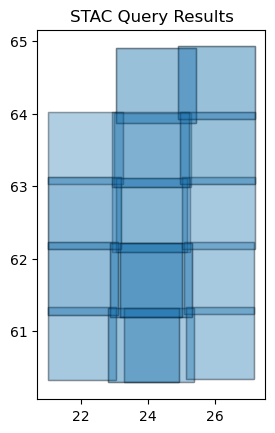

In [19]:
fig = gdf.plot(
    edgecolor="black",
    alpha=0.05,
)
_ = fig.set_title("STAC Query Results")

To plot items with a zoomable map see this example: https://stacspec.org/en/tutorials/access-sentinel-2-data-aws#Plot-STAC-Items-on-a-Map

## Retrieving data

Create `xarray` datacube from the items. Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of all the assets. This will be fast, because the actual data is not fetched yet. How does the datacube look like?

In [20]:
# Define smaller bbox
# Convert lat-lon point to the data's UTM coordinate reference system, then use that to slice the `x` and `y` dimensions, which are indexed by their UTM coordinates.
x_utm, y_utm = pyproj.Proj("EPSG:32635")(lon, lat)
buffer = 10000  # meters
x_utm-buffer

375988.18431813555

In [21]:
%time 
cube = stackstac.stack(
    items=item_collection,
    bounds=(x_utm-buffer, y_utm-buffer, x_utm+buffer, y_utm+buffer), 
    assets=["B04_60m", "B03_60m", "B02_60m"],
    epsg=32635
).squeeze() 
# When item_collection contains multiple epsg's, epsg value needs to be provided
cube

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


<xarray.DataArray 'stackstac-d306884b2a2facac6446057a6676deeb' (time: 9,
                                                                band: 3,
                                                                y: 311, x: 310)>
dask.array<fetch_raster_window, shape=(9, 3, 311, 310), dtype=float64, chunksize=(1, 1, 311, 310), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time                 (time) datetime64[ns] 2021-08-05 ... 2021-09-27
    id                   (time) <U60 'S2A_MSIL2A_20210805T095031_N0301_R079_T...
  * band                 (band) <U7 'B04_60m' 'B03_60m' 'B02_60m'
  * x                    (x) float64 3.76e+05 3.76e+05 ... 3.959e+05 3.96e+05
  * y                    (y) float64 6.683e+06 6.682e+06 ... 6.663e+06 6.662e+06
    eo:cloud_cover       (time) int64 11 15 9 11 2 8 17 0 3
    ...                   ...
    title                (band) <U7 'B04_60m' 'B03_60m' 'B02_60m'
    gsd                  int64 60
    common_name          (band) <U5 'red' 'green' 'blue'
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32635
Attributes:
    spec:           RasterSpec(epsg=32635, bounds=(375979.36496072705, 666239...
    crs:            epsg:32635
    transform:      | 64.72, 0.00, 375979.36|\n| 0.00,-64.70, 6682512.93|\n| ...
    resolution_xy:  (64.72359527642057, 64.69974275492794)

Use xarray's `resample` to create 1-month median composites.

In [22]:
monthly = cube.resample(time="MS").median("time", keep_attrs=True)
monthly

<xarray.DataArray 'stackstac-d306884b2a2facac6446057a6676deeb' (time: 2,
                                                                band: 3,
                                                                y: 311, x: 310)>
dask.array<stack, shape=(2, 3, 311, 310), dtype=float64, chunksize=(1, 3, 311, 310), chunktype=numpy.ndarray>
Coordinates:
  * band                 (band) <U7 'B04_60m' 'B03_60m' 'B02_60m'
  * x                    (x) float64 3.76e+05 3.76e+05 ... 3.959e+05 3.96e+05
  * y                    (y) float64 6.683e+06 6.682e+06 ... 6.663e+06 6.662e+06
    proj:shape           object {1830}
    title                (band) <U7 'B04_60m' 'B03_60m' 'B02_60m'
    gsd                  int64 60
    common_name          (band) <U5 'red' 'green' 'blue'
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32635
  * time                 (time) datetime64[ns] 2021-08-01 2021-09-01
Attributes:
    spec:           RasterSpec(epsg=32635, bounds=(375979.36496072705, 666239...
    crs:            epsg:32635
    transform:      | 64.72, 0.00, 375979.36|\n| 0.00,-64.70, 6682512.93|\n| ...
    resolution_xy:  (64.72359527642057, 64.69974275492794)

So far no data has been downloaded, nor anything computed with actual data. Data size has become 7 Mb, which will actually be downloaded. In this example the final data size is very small, but Dask is good also in handling much bigger amounts of data, also bigger than fits to memory.

To start the process use `compute()`. The process can be followed from Dask Dashboard or Dask Lab Extension.

In [23]:
# %%time
# data = monthly.compute()

Show the resulting images.

CPU times: user 1.91 s, sys: 340 ms, total: 2.25 s
Wall time: 8.37 s


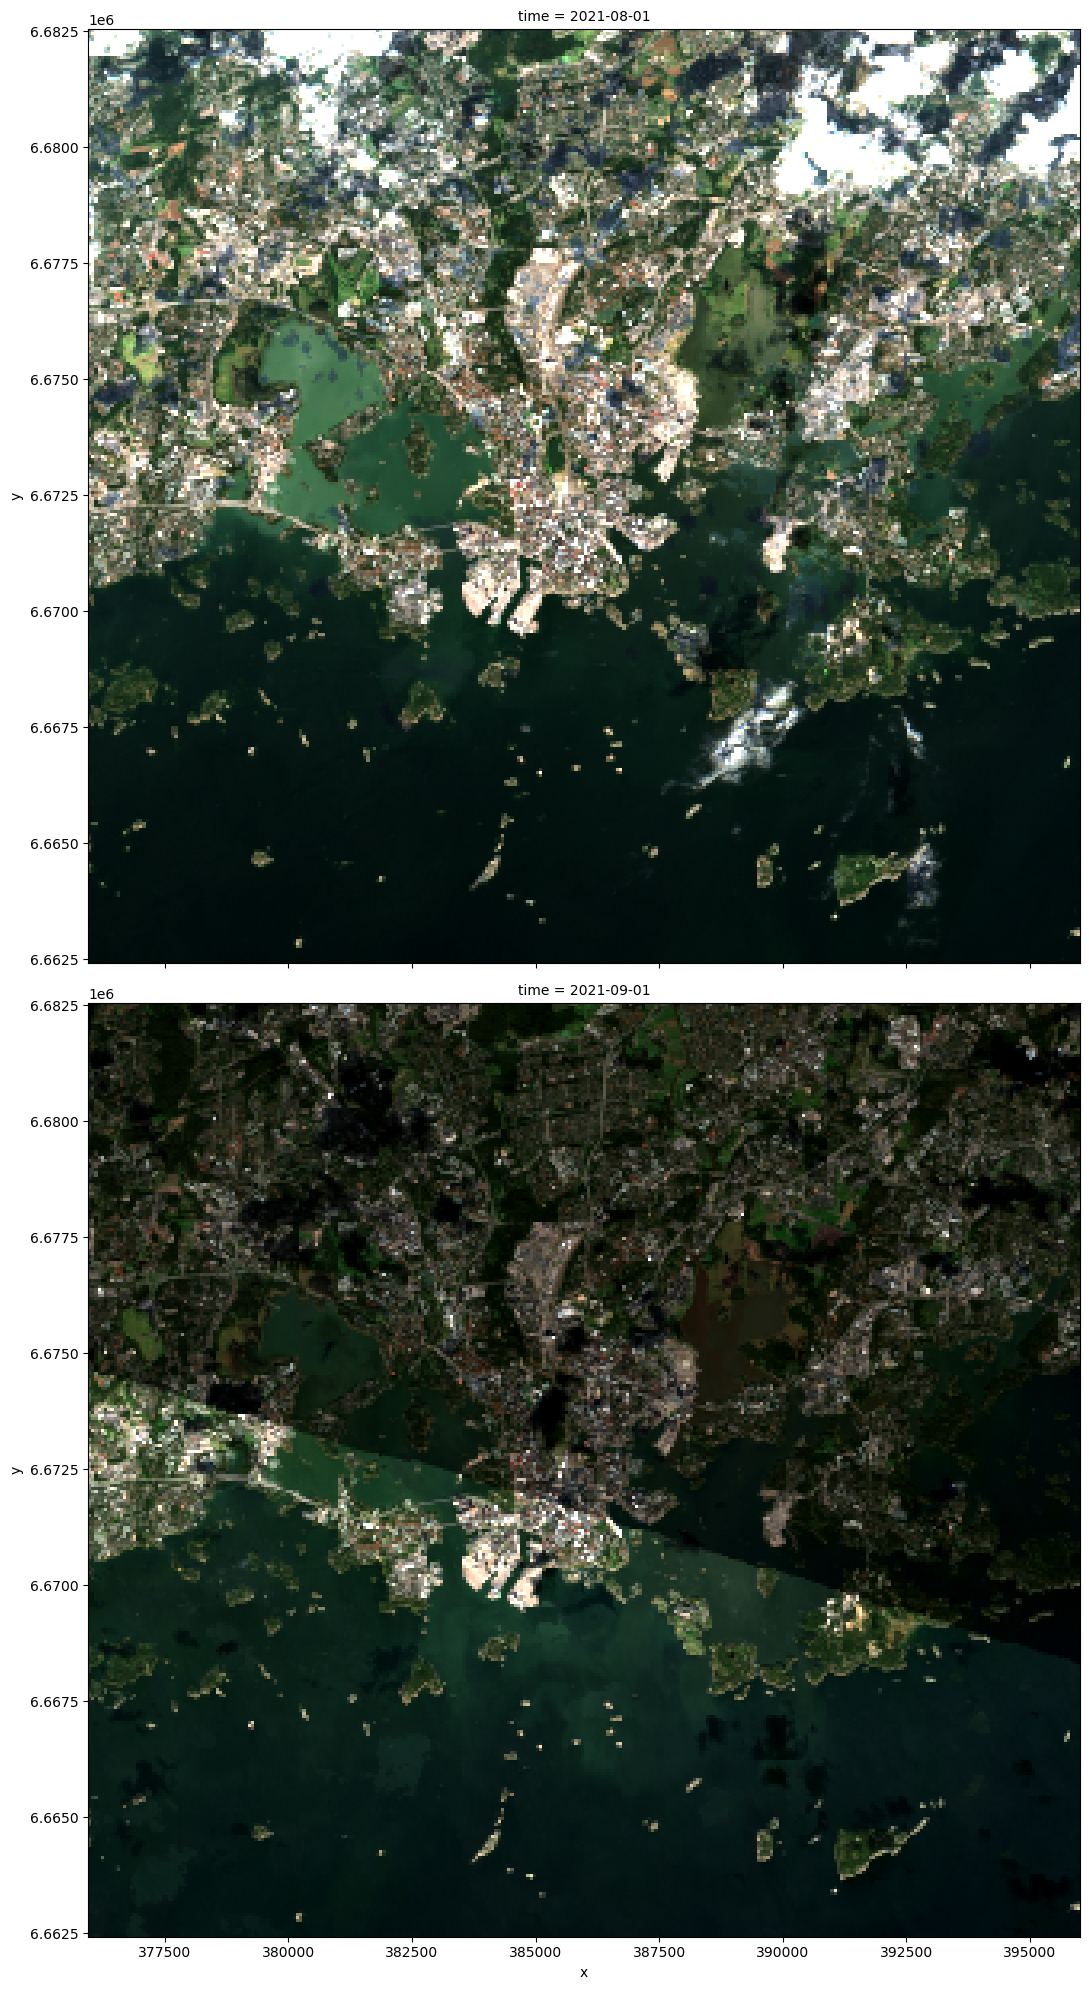

In [24]:
%%time
monthly.plot.imshow(row="time", rgb="band", robust=True, size=10);

### One item info

In [25]:
i = 0
item = item_collection[i]
print(f"{i}: {item}")
print(f"{i}: {item.bbox}")
print(f"{i}: {item.properties}")
print(f"Available assets: {item.assets.keys()}")
for key in item.assets.keys():
        print(f"{key}: {item.assets[key]}")

0: <Item id=S2A_MSIL2A_20210927T100031_N0301_R122_T35VLG_20210927T105150>
0: [23.37063835895766, 59.40296748051331, 25.409527326761424, 60.42638503368436]
0: {'datetime': '2021-09-27T00:00:00Z', 'eo:cloud_cover': 3}
Available assets: dict_keys(['thumbnail', 'B02_10m', 'B03_10m', 'B04_10m', 'B08_10m', 'TCI_10m', 'WVP_10m', 'AOT_20m', 'B02_20m', 'B03_20m', 'B04_20m', 'B05_20m', 'B06_20m', 'B07_20m', 'B11_20m', 'B12_20m', 'B8A_20m', 'SCL_20m', 'TCI_20m', 'WVP_20m', 'AOT_60m', 'B01_60m', 'B02_60m', 'B03_60m', 'B04_60m', 'B05_60m', 'B06_60m', 'B07_60m', 'B09_60m', 'B11_60m', 'B12_60m', 'B8A_60m', 'SCL_60m', 'TCI_60m', 'WVP_60m'])
thumbnail: <Asset href=https://a3s.fi/Sentinel2-MSIL2A-cloud-0-95-2021-T35VLG/S2A_MSIL2A_20210927T100031_N0301_R122_T35VLG_20210927T105150.SAFE/GRANULE/L2A_T35VLG_A032723_20210927T100030/QI_DATA/T35VLG_20210927T100031_PVI.jp2>
B02_10m: <Asset href=https://a3s.fi/Sentinel2-MSIL2A-cloud-0-95-2021-T35VLG/S2A_MSIL2A_20210927T100031_N0301_R122_T35VLG_20210927T105150.SAF

## Working with rasterio or other tools

It is possible to use the STAC also when working with rasterio or other tools, but then the URLs must be manually retrieved.

In [26]:
import rasterio
from rasterio.plot import show

Select item and asset, retrieve URL.

In [27]:
url = item_collection[3].assets['B04_60m'].href
url

'https://a3s.fi/Sentinel2-MSIL2A-cloud-0-95-2021-T35VLG/S2A_MSIL2A_20210904T095031_N0301_R079_T35VLG_20210904T104136.SAFE/GRANULE/L2A_T35VLG_A032394_20210904T095030/IMG_DATA/R60m/T35VLG_20210904T095031_B04_60m.jp2'

In [28]:
%time
dataset = rasterio.open(url)
print(f"Transform: {dataset.transform}")
print(f"Transform: {dataset.shape}")
print(f"Transform: {dataset.crs}")

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.58 µs
Transform: | 60.00, 0.00, 300000.00|
| 0.00,-60.00, 6700020.00|
| 0.00, 0.00, 1.00|
Transform: (1830, 1830)
Transform: EPSG:32635


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs


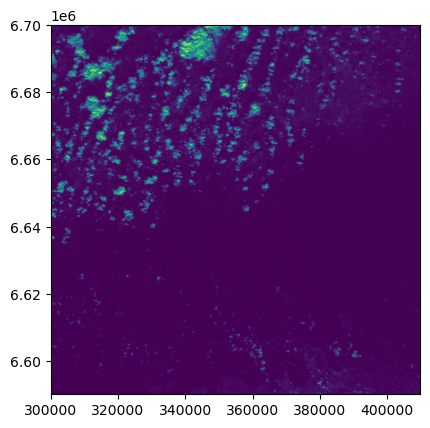

<AxesSubplot: >

In [29]:
%time
show(dataset.read(), transform=dataset.transform)

Use GDAL with the URL.

In [30]:
%time
!gdalinfo {url}

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs
Driver: JP2OpenJPEG/JPEG-2000 driver based on OpenJPEG library
Files: /vsimem/http_1/T35VLG_20210904T095031_B04_60m.jp2
Size is 1830, 1830
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 35N",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION[